# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [18]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import gzip
import shutil

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [20]:
def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    filenames = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                 "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]

    os.makedirs("./data/MNIST/raw", exist_ok=True)

    for filename in filenames:
        url = base_url + filename
        file_path = os.path.join("./data/MNIST/raw", filename)

        # Download the file
        urllib.request.urlretrieve(url, file_path)

        # Extract the gzipped file
        with gzip.open(file_path, "rb") as f_in:
            with open(file_path[:-3], "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        # Remove the gzipped file
        os.remove(file_path)

download_mnist()

In [21]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the training set into training, validation, and test sets (60-20-20 split)
train_size = int(0.6 * len(trainset))
val_size = int(0.2 * len(trainset))
test_size = len(trainset) - train_size - val_size

trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose transforms.ToTensor() to convert the images to PyTorch tensors as the input format for neural networks. I used transforms.Normalize() to center the pixel values around zero and scale them, improving training stability and convergence. Preprocessing is crucial for better neural network performance and faster training.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [22]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


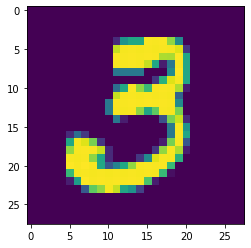

7


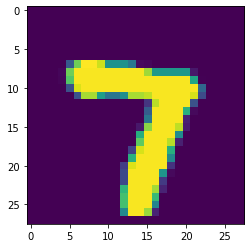

9


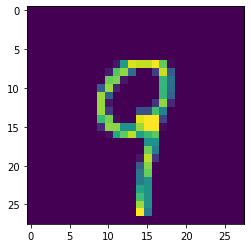

3


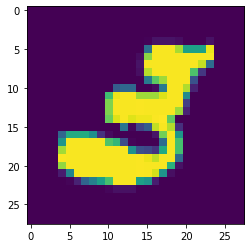

9


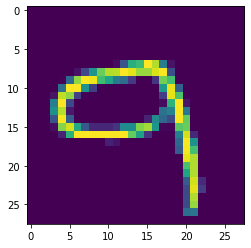

7


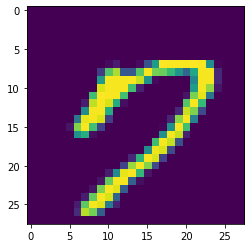

8


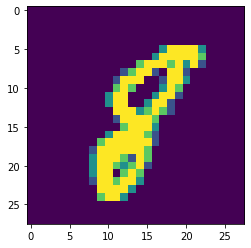

0


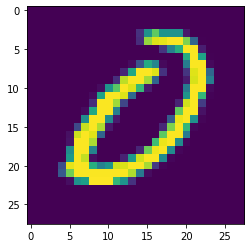

1


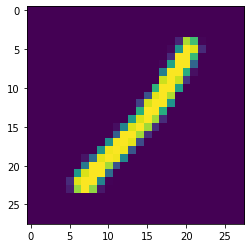

8


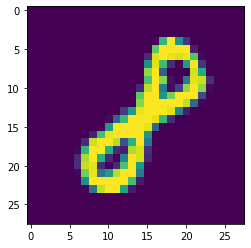

In [23]:
# Explore data
# View 5 images from the training set
show5(trainloader)

# View 5 images from the test set
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [25]:
## YOUR CODE HERE ##
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 1 input channel, 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 16 input channels, 32 output channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Input size after pooling: 32x7x7, Output size: 128
        self.fc2 = nn.Linear(128, 64)          # Input size: 128, Output size: 64
        self.fc3 = nn.Linear(64, 10)           # Input size: 64, Output size: 10 (number of classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the 3D tensor into a 1D tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the CNN model
cnn_model = SimpleCNN()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
# Instantiate the CNN model
cnn_model = SimpleCNN()

# Specify the loss function
loss_function = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
cnn_model.to(device)

# Define the number of epochs for training
num_epochs = 5

# Lists to store training and validation loss at each epoch
train_losses = []
val_losses = []

# Define a function for evaluating the model on the validation set
def evaluate_model(model, loss_function, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = (100.0 * correct) / total
    return val_loss, val_accuracy

# Define a function for training the model
def train_model(model, loss_function, optimizer, train_loader, num_epochs, print_every=250):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader, 0):
            # Move the data to the selected device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = loss_function(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Record the average loss
            total_loss += loss.item()
            
            # Print the loss every print_every batches
            if batch_idx % print_every == print_every - 1:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {total_loss/print_every:.4f}")
                total_loss = 0.0
        
        # Calculate validation loss and accuracy at the end of each epoch
        val_loss, _ = evaluate_model(model, loss_function, valloader)
        val_losses.append(val_loss)
        
        # Record training loss at each epoch
        train_losses.append(total_loss / len(train_loader))
        
        print(f"Epoch {epoch+1} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    # Return the list of training losses
    return train_losses

Plot the training loss (and validation loss/accuracy, if recorded).

Epoch 1, Batch 250/1125, Loss: 1.2833
Epoch 1, Batch 500/1125, Loss: 0.1998
Epoch 1, Batch 750/1125, Loss: 0.1155
Epoch 1, Batch 1000/1125, Loss: 0.0929
Epoch 1 - Training Loss: 0.0095, Validation Loss: 0.1089
Epoch 2, Batch 250/1125, Loss: 0.0645
Epoch 2, Batch 500/1125, Loss: 0.0677
Epoch 2, Batch 750/1125, Loss: 0.0746
Epoch 2, Batch 1000/1125, Loss: 0.0571
Epoch 2 - Training Loss: 0.0068, Validation Loss: 0.0666
Epoch 3, Batch 250/1125, Loss: 0.0476
Epoch 3, Batch 500/1125, Loss: 0.0460
Epoch 3, Batch 750/1125, Loss: 0.0427
Epoch 3, Batch 1000/1125, Loss: 0.0420
Epoch 3 - Training Loss: 0.0038, Validation Loss: 0.0470
Epoch 4, Batch 250/1125, Loss: 0.0269
Epoch 4, Batch 500/1125, Loss: 0.0328
Epoch 4, Batch 750/1125, Loss: 0.0302
Epoch 4, Batch 1000/1125, Loss: 0.0311
Epoch 4 - Training Loss: 0.0032, Validation Loss: 0.0515
Epoch 5, Batch 250/1125, Loss: 0.0178
Epoch 5, Batch 500/1125, Loss: 0.0217
Epoch 5, Batch 750/1125, Loss: 0.0224
Epoch 5, Batch 1000/1125, Loss: 0.0276
Epoch 5

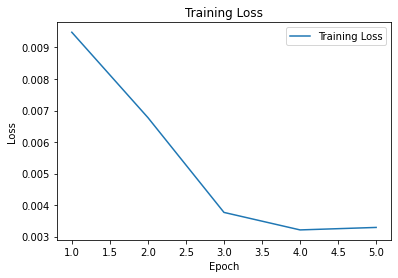

In [28]:
# Train the model and record losses
train_losses = train_model(cnn_model, loss_function, optimizer, trainloader, valloader, num_epochs)

# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [29]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (100.0 * correct) / total
    return accuracy

# Test the model on the test set
test_accuracy = test_model(cnn_model, testloader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.67%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [30]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [35]:
def save_checkpoint(model, file_path):
    try:
        # Save the model state dictionary to the checkpoint file
        torch.save(model.state_dict(), file_path)
        print("Checkpoint saved successfully.")
    except Exception as e:
        print(f"Error saving the checkpoint: {e}")

In [37]:
checkpoint_path = './cnn_model_checkpoint.pth'
save_checkpoint(cnn_model, checkpoint_path)

Checkpoint saved successfully.
